In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
import HSS

In [2]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
font = {#'family' : 'Helvetica',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
path_plot = '/users/caganze/research/stellarstreams/figures/'
path_data = '/users/caganze/research/stellarstreams/data/'

In [4]:
#use NFW POTENTIAL BECAUSE THE HALO? 
pot = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s, r_s=15*u.kpc, units=galactic)
#CONSTRUCT A HAMILTONIAN
H = gp.Hamiltonian(pot)

In [5]:
def generate_stream(mass, prog_w0, dt=8 * u.Myr, nsteps=1000):
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)
    stream, prog = gen.run(prog_w0, prog_mass ,dt=dt, n_steps=nsteps)
    return stream, prog

def generate_uniform_background(n):
    Nstars = int(n *1000)  #make these with 1,2,3,4...,10 times the amount of stars such that f = nstar/nbkg are the same.
    a = 0.3
    r = np.random.uniform(low=0, high=(a)**2, size = (Nstars)) #radius of scramble data, high=radius data **2         \
    angle = np.random.uniform(low=0, high=2.*np.pi, size = (Nstars ))
    x = np.sqrt(r) * np.cos(angle)
    y = np.sqrt(r) * np.sin(angle)
    return x, y

def plot_hss(pos, HSS_args):
    HSS_args['pos']=pos[0], pos[-1]  #in deg here, can also be unitless
    HSS_args['kpc_conversion'] = np.pi * HSS_args['d_galaxy'] / 180.


    HSS.RT_plot(HSS_args['pos'], HSS_args['unit'], HSS_args['kpc_conversion'],\
                    HSS_args['delta_t'], HSS_args['drho'],  HSS_args['outlier'],\
                    HSS_args['pointsize'], HSS_args['mask'], HSS_args['filename'],
                path_plot, HSS_args['verbose'], HSS_args['rho_edge'])
    
    return 

def circular_mask(x, y, cent, radius):
    """
    Create a fake circular grap in a stellar stream
    
    
    Input: center, 3d-radius all in kpc
    
    returns a mask array
    """
    #compute absolute distance 
    r= ((x-cent[0])**2+(y-cent[1])**2)**0.5
    return  r> radius

def rotate(x, y, ang):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    c=(np.nanmedian(x), np.nanmedian(y))
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

In [6]:
df = ms.FardalStreamDF()
prog_w0 = gd.PhaseSpacePosition(pos=[10., 1, 3.] * u.kpc,
                                vel=[0, 170, 0.] * u.km/u.s)
gen = ms.MockStreamGenerator(df, H)
prog_mass = 1e4 * u.Msun
stream, prog = gen.run(prog_w0, prog_mass,
                       dt=1 * u.Myr, t1=0.0*u.Myr, t2=10*u.Gyr)

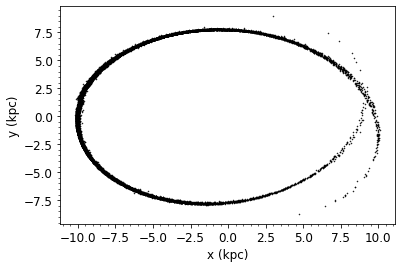

In [7]:
#creating mock stream
fig, ax=plt.subplots()
ax.scatter(stream.x, stream.y, s=1, c='k', marker='.')
ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
ax.minorticks_on()

In [8]:
stream_r=(np.array([stream.x.value**2+stream.y.value**2+stream.z.value**2])**0.5).flatten()

In [9]:
#stream_r.l

In [10]:
x, y=stream.x.value/stream_r, stream.y.value/stream_r
mask=~np.logical_or(np.logical_or(x <-1, x>-0.5), np.logical_or(y <0.1, y>0.3))
#mask=np.ones_like(x).astype(bool)

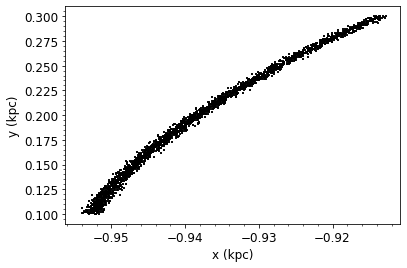

In [11]:
#creating mock stream
fig, ax=plt.subplots()
ax.scatter(x[mask], y[mask], s=1, c='k', marker=',')
ax.set(xlabel='x (kpc)', ylabel='y (kpc)')
ax.minorticks_on()

In [12]:
x= x[mask][::10]
y=y[mask][::10]

In [13]:
#

In [14]:
#generate uniform background
back_x, back_y= generate_uniform_background(2)

In [15]:
#concatenate arrays 
comb_x, comb_y= np.concatenate([x , back_x+x.mean()] ), \
np.concatenate([y, back_y+y.mean()] )

In [16]:
#slight rotation to avoid strange angles
comb_x, comb_y=rotate(comb_x, comb_y, np.pi/3)

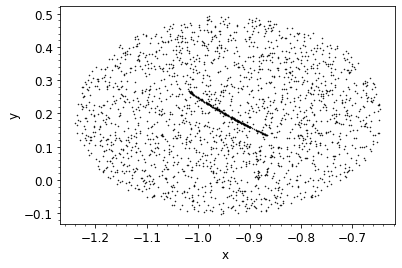

In [17]:
#creating mock stream
fig, ax=plt.subplots()
ax.scatter(comb_x, comb_y, s=1, c='k', marker='.')
ax.set(xlabel='x ', ylabel='y')
ax.minorticks_on()

In [18]:
#set HSS parameters
HSS_args={'unit':"unitless",
          'd_galaxy': 1 , #this probably doesn't apply                     
          'delta_t': .1,     
          'drho' : 0.008,     
          'outlier': 150, 
          'pointsize': 1,
          'mask': False,
          'verbose': True,
          'rho_edge': False,
         'filename': None}

In [19]:
HSS_args

{'unit': 'unitless',
 'd_galaxy': 1,
 'delta_t': 0.1,
 'drho': 0.008,
 'outlier': 150,
 'pointsize': 1,
 'mask': False,
 'verbose': True,
 'rho_edge': False,
 'filename': None}

-------------------------------

Stream detected at an angle of:
theta_peak = [48.8][deg]

Stream detected at a minimum Euclidian distance of:
rho_peak = [-0.]

Stream detected at a significance of:
-(logPr(X>=k)) = [298.29]

-------------------------------

plots saved in /users/caganze/research/stellarstreams/figures/


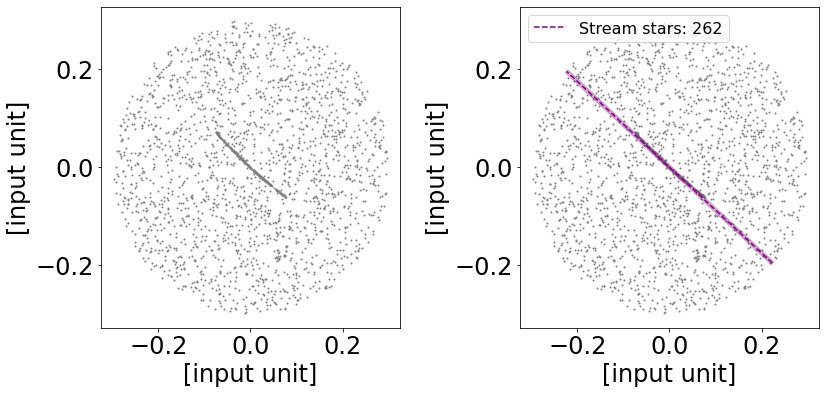

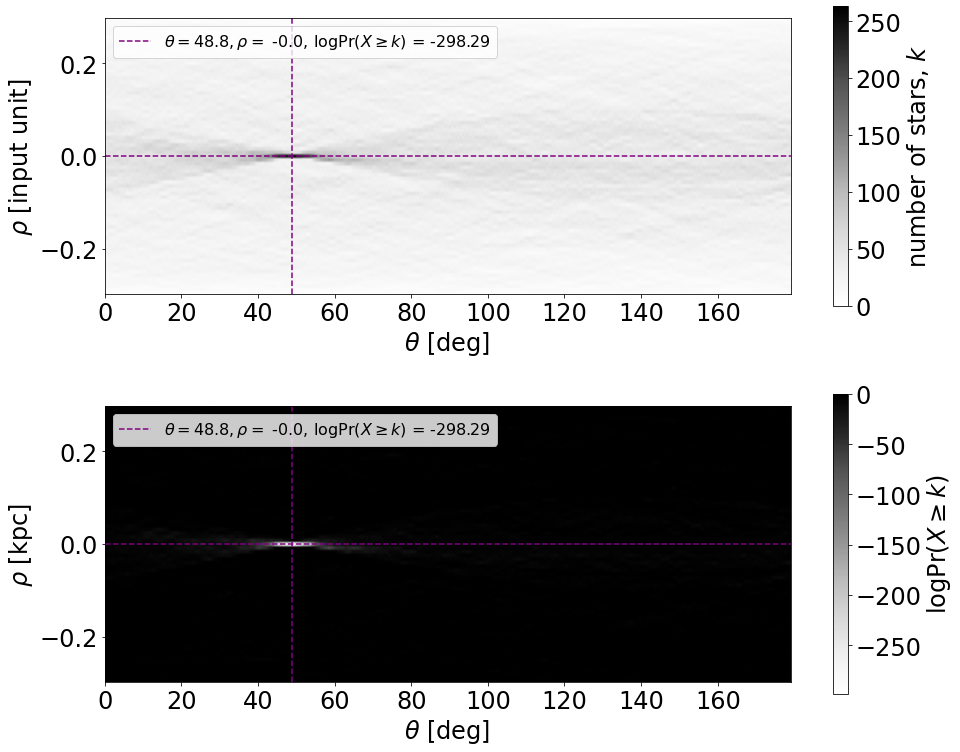

In [20]:
#for dr in [1e-3, 2e-3, 2e-3,  2e-3, 1e-2]:
#dr=0.06
HSS_args['filename']='gold_hss'
plot_hss([comb_x, comb_y],    HSS_args)
